In [1]:
import setigen as stg
import blimpy as bl
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

/home/obs/.conda/envs/seticore/lib/python3.10/site-packages/blimpy/__init__.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [23]:
fil_file = '../../random-data/guppi_60703_16858_008036_TIC286923464_ON_0001.0001.fil'
wf = bl.Waterfall(fil_file)

In [24]:
frame = stg.Frame(waterfall=fil_file)

In [25]:
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(500_000),
                                            drift_rate=2*u.Hz/u.s),
                          stg.constant_t_profile(level=1),
                          stg.box_f_profile(width=20*u.Hz),
                          stg.constant_bp_profile(level=1))

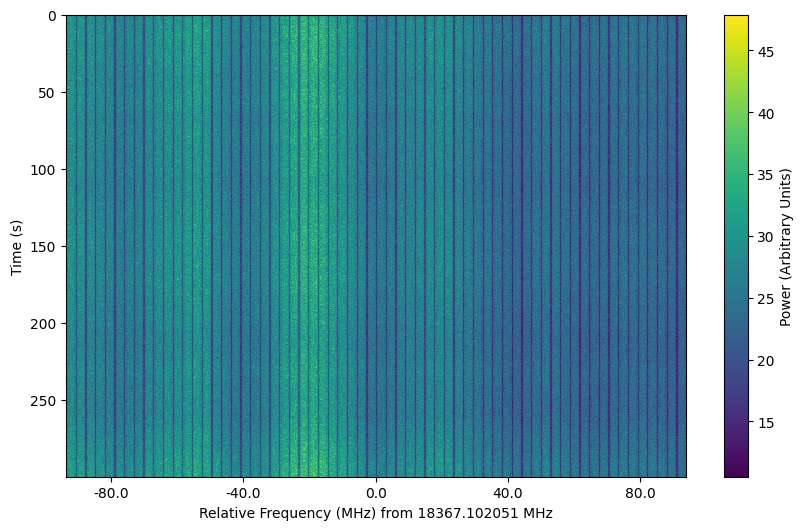

In [26]:
fig = plt.figure(figsize=(10,6))
frame.plot(db=False)